# Introduction

We'll validate our extraction of mental functions from article texts by comparing the term occurrences to manual annotations of articles in the BrainMap database.


# Load the data

In [1]:
import pandas as pd

## BrainMap metadata 

In [2]:
df = pd.read_csv("../data/metadata.csv", encoding="latin-1")
df = df.loc[df["SOURCE"] == "BrainMap"]
len(df)

3346

In [3]:
pmids = df["PMID"].astype(int)
df["PMID"] = pmids

In [4]:
df.head(3)

,PMID,DOI,KEY,SOURCE,AUTHORS,YEAR,MONTH,JOURNAL,TITLE,PAGES,VOLUME,ABSTRACT_URL,NUM_COORDINATES,MNI_COORDINATES,BRAINMAP_ID,BEHAVIORAL_DOMAIN,EXPERIMENT,DESCRIPTION
0,1402966,NaN,"Dolan R J, 1992",BrainMap,Dolan R J|Bench C J|Brown R G|Scott L C|Fristo...,1992.0,Sep,"Journal of Neurology, Neurosurgery, and Psychi...",Regional cerebral blood flow abnormalities in ...,768-773,55,http://www.ncbi.nlm.nih.gov/entrez/query.fcgi?...,7.0,"-7.66,51.87,-8.33;-5.51,56.46,-4.28;-5.48,58.9...",6030020.0,"['Action.Rest', 'Action.Rest']","['Unimpaired > Impaired', 'Impaired > Unimpair...",Patients with depression who were cognitively ...
1,1410086,NaN,"Bench C J, 1992",BrainMap,Bench C J|Friston K J|Brown R G|Scott L C|Frac...,1992.0,Aug,Psychological Medicine,The anatomy of melancholia - focal abnormaliti...,607-615,22,http://www.ncbi.nlm.nih.gov/entrez/query.fcgi?...,10.0,"-13.68,29.54,33.76;-15.76,23.53,38.75;-39.5,38...",6030018.0,"['Action.Rest', 'Action.Rest', 'Action.Rest']","['Normals > Depressed', 'Unimpaired > Impaired...",Patients with depression and normal subjects u...
2,1448149,10.1038/360339a0,"Zatorre R J, 1992",BrainMap,Zatorre R J|Jones-Gotman M|Evans A C|Meyer E,1992.0,Nov,Nature,Functional localization and lateralization of ...,339-340,360,http://www.ncbi.nlm.nih.gov/entrez/query.fcgi?...,6.0,"-21.56,5.58,-27.71;22.3,6.36,-21.58;18.98,41.4...",8110311.0,['Perception.Olfaction'],['Odor vs. Odorless'],Subjects underwent 2 conditions in which they ...


## Document-term matrix

In [5]:
dtm = pd.read_csv("../data/text/dtm_190325.csv.gz", 
                  compression="gzip", index_col=0)
dtm = dtm.loc[pmids]
len(dtm)

3346

In [6]:
dtm.head(3)

,2_step,2step,3d_object,abductive_reasoning,aberrant_behavior,aberrant_behavior_checklist,ability,abstinence_syndrome,abstract_analogy,abstract_concrete_task,...,writing_task,yale_global_tic_severity,yale_global_tic_severity_scale,ybocs_total_score,young_mania_rating_scale,youth_drinking,youth_life_stress_interview,zimbardo_time_perspective_inventory,zoo_map_test,zuckerman_sensation_seeking_scale
1402966,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1410086,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1448149,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
dtm.max()[:5]

2_step                  2
2step                   5
3d_object              25
abductive_reasoning     0
aberrant_behavior       1
dtype: int64

## Vector space model

In [8]:
vsm = pd.read_csv("../data/text/glove_gen_n100_win15_min5_iter500_190428.txt",
                  sep=" ", index_col=0, header=None)
vsm.shape

(350544, 100)

In [9]:
vsm.head(3)

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,,,,,,,,,,,,,,,,,,,,,
.,-0.067831,0.549335,-0.156630,0.410737,0.116248,-0.059299,-0.154392,-0.155805,-0.231066,0.090840,...,0.352904,0.046004,0.354009,-0.235567,0.090256,0.686937,-0.138293,-0.096606,-0.208885,-0.287169
al,0.664308,-0.245204,-0.449092,0.550044,-0.590212,-0.022113,0.460102,0.469743,-0.016148,0.147987,...,0.203895,-0.033772,0.329714,-0.293984,-0.466299,0.559178,1.020166,1.065667,0.184119,-0.328188
et,0.710913,-0.233848,-0.424211,0.602548,-0.549417,0.023619,0.426391,0.555671,-0.000479,0.179847,...,0.228177,0.041510,0.304830,-0.274054,-0.531494,0.603370,1.117633,1.240699,0.192895,-0.293243


# Load the BrainMap taxonomy

In [10]:
def process_annotations(annotations):
    annotations = annotations.replace("[", "").replace("]", "")
    annotations = annotations.replace("'", "").replace(" ", "").split(",")
    annotations = [a for a in annotations if "." in a]
    return annotations

## Behavioral subdomains

In [11]:
subdomains = []
for i, row in df.iterrows():
    subdomains += process_annotations(row["BEHAVIORAL_DOMAIN"])     
subdomains = sorted(list(set(subdomains)))
subdomains[:5]

['Action.Execution',
 'Action.Execution.Speech',
 'Action.Imagination',
 'Action.Inhibition',
 'Action.MotorLearning']

## Behavioral domains

In [12]:
domains = sorted(list(set([s.split(".")[0] for s in subdomains])))
domains

['Action',
 'Cognition',
 'Emotion',
 'Interoception',
 'Perception',
 'Pharmacology']

# Load the BrainMap annotations

In [13]:
dam = pd.DataFrame(0, index=pmids, columns=subdomains)
for pmid in pmids:
    annotations = process_annotations(df.loc[df["PMID"] == pmid, "BEHAVIORAL_DOMAIN"].values[0])
    for subdomain in annotations:
        dam.loc[pmid, subdomain] = dam.loc[pmid, subdomain] + 1
dam.head()

,Action.Execution,Action.Execution.Speech,Action.Imagination,Action.Inhibition,Action.MotorLearning,Action.Observation,Action.Preparation,Action.Rest,Cognition.Attention,Cognition.Language,...,Pharmacology.Caffeine,Pharmacology.Capsaicin,Pharmacology.Cocaine,Pharmacology.Marijuana,Pharmacology.Nicotine,Pharmacology.Non-SteroidalAnti-InflammatoryDrugs,Pharmacology.Opioids,Pharmacology.PsychiatricMedications,Pharmacology.PsychiatricMedications.Antidepressants,Pharmacology.SteroidsandHormones.Estrogen
PMID,,,,,,,,,,,,,,,,,,,,,
1402966,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1410086,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1448149,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1486459,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1486460,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Reweight by TF-IDF

In [14]:
import numpy as np

In [15]:
def tfidf(df):
    
    # Rows are documents, columns are terms
    # Inverse document frequencies
    doccount = float(df.shape[0])
    freqs = df.astype(bool).sum(axis=0)
    idfs = np.log(doccount / freqs)
    idfs[np.isinf(idfs)] = 0.0  # log(0) = 0
    
    # Term frequencies
    terms_in_doc = df.sum(axis=1)
    tfs = (df.T / terms_in_doc).T
    
    # TF-IDF reweighting
    X = tfs * idfs
    
    # Fill NA with 0
    X = X.fillna(0.0)
    
    return X

In [16]:
dtm_tfidf = tfidf(dtm)

In [17]:
dtm_tfidf.head(3)

,2_step,2step,3d_object,abductive_reasoning,aberrant_behavior,aberrant_behavior_checklist,ability,abstinence_syndrome,abstract_analogy,abstract_concrete_task,...,writing_task,yale_global_tic_severity,yale_global_tic_severity_scale,ybocs_total_score,young_mania_rating_scale,youth_drinking,youth_life_stress_interview,zimbardo_time_perspective_inventory,zoo_map_test,zuckerman_sensation_seeking_scale
1402966,0.0,0.0,0.0,0.0,0.0,0.0,0.002921,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1410086,0.0,0.0,0.0,0.0,0.0,0.0,0.002322,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1448149,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Drop terms that never occurred
dtm = dtm.loc[:, (dtm != 0).any(axis=0)]
dtm_tfidf = dtm_tfidf.loc[:, (dtm_tfidf != 0).any(axis=0)]
dtm_tfidf.shape

(3346, 3172)

In [19]:
# Drop terms not in VSM index
dtm = dtm[[term for term in dtm.columns if term in vsm.index]]
dtm_tfidf = dtm_tfidf[[term for term in dtm_tfidf.columns if term in vsm.index]]
dtm_tfidf.shape

(3346, 2941)

In [20]:
dtm.shape

(3346, 2941)

# Check that BrainMap terms occur in VSM

In [21]:
from nltk.stem import WordNetLemmatizer

In [22]:
phrases = ["heartbeat_detection", "motor_learning", "non-steroidal_anti-inflammatory_drugs", 
           "psychiatric_medications", "respiration_regulation", "social_cognition", "steroids_and_hormones"]
for phrase in phrases:
    if phrase not in vsm.index:
        print(phrase)

heartbeat_detection
non-steroidal_anti-inflammatory_drugs
psychiatric_medications
respiration_regulation
steroids_and_hormones


In [23]:
phrases2terms = {"heartbeat_detection": ["heartbeat"], "non-steroidal_anti-inflammatory_drugs": ["nsaids"],
                 "psychiatric_medications": ["psychotropics"], "respiration_regulation": ["respiration"], 
                 "steroids_and_hormones": ["steroids", "hormones"]}

In [24]:
def process_subdomain(subdomain):
    terms = subdomain.lower()
    terms = terms.replace("/", ".").replace("(", ".").replace(")", "")
    terms = terms.replace(".other", "") # Placeholder in BrainMap
    terms = terms.replace(".baroregulation", "") # Does not occur in VSM index
    terms = terms.split(".")
    for phrase in phrases:
        for i, term in enumerate(terms):
            if term == phrase.replace("_", ""):
                terms[i] = phrase
                if phrase in phrases2terms.keys():
                    terms[i] = phrases2terms[phrase][0]
                    if len(phrases2terms[phrase]) > 1:
                        terms += phrases2terms[phrase][1:]
    terms = [WordNetLemmatizer().lemmatize(term) for term in terms]
    return terms

In [25]:
bm_terms = []
for subdomain in subdomains:
    bm_terms += process_subdomain(subdomain)
bm_terms = sorted(list(set(bm_terms)))
bm_terms

['action',
 'alcohol',
 'amphetamine',
 'anger',
 'antidepressant',
 'anxiety',
 'attention',
 'audition',
 'caffeine',
 'capsaicin',
 'cocaine',
 'cognition',
 'color',
 'disgust',
 'embarrassment',
 'emotion',
 'estrogen',
 'execution',
 'explicit',
 'fear',
 'gain',
 'gastrointestinal',
 'genitourinary',
 'gi',
 'gu',
 'guilt',
 'gustation',
 'happiness',
 'heartbeat',
 'hormone',
 'humor',
 'hunger',
 'imagination',
 'implicit',
 'inhibition',
 'intensity',
 'interoception',
 'language',
 'loss',
 'marijuana',
 'memory',
 'methamphetamine',
 'motion',
 'motor_learning',
 'music',
 'negative',
 'neutral',
 'nicotine',
 'nsaid',
 'observation',
 'olfaction',
 'opioids',
 'orthography',
 'osmoregulation',
 'pain',
 'perception',
 'pharmacology',
 'phonology',
 'positive',
 'preparation',
 'psychotropics',
 'punishment',
 'reasoning',
 'respiration',
 'rest',
 'reward',
 'sadness',
 'semantics',
 'sexuality',
 'shape',
 'sleep',
 'social_cognition',
 'somatic',
 'somesthesis',
 'spatia

In [26]:
for term in bm_terms:
    if term not in vsm.index:
        print(term)

In [27]:
dtm_bm = pd.DataFrame(0, index=pmids, columns=bm_terms)
for pmid in pmids:
    annotations = process_annotations(df.loc[df["PMID"] == pmid, "BEHAVIORAL_DOMAIN"].values[0])
    article_terms = []
    for subdomain in annotations:
        article_terms += process_subdomain(subdomain)
    for term in article_terms:
        dtm_bm.loc[pmid, term] = dtm_bm.loc[pmid, term] + 1
dtm_bm.head()

,action,alcohol,amphetamine,anger,antidepressant,anxiety,attention,audition,caffeine,capsaicin,...,speech,steroid,syntax,temporal,thermoregulation,thirst,valence,vestibular,vision,working
PMID,,,,,,,,,,,,,,,,,,,,,
1402966,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1410086,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1448149,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1486459,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1486460,0,0,0,0,0,0,0,1,0,0,...,4,0,0,0,0,0,0,0,0,0


In [28]:
dtm_bm_tfidf = tfidf(dtm_bm)
dtm_bm_tfidf.head()

,action,alcohol,amphetamine,anger,antidepressant,anxiety,attention,audition,caffeine,capsaicin,...,speech,steroid,syntax,temporal,thermoregulation,thirst,valence,vestibular,vision,working
PMID,,,,,,,,,,,,,,,,,,,,,
1402966,0.803376,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1410086,0.803376,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1448149,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1486459,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1486460,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.220363,0.0,0.0,...,0.74116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Compute semantic similarity

Cosine similarity of TF-IDF weighted term occurrences and BrainMap annotations for each article (n=3,346)

In [29]:
from scipy.spatial.distance import cdist, cosine
from scipy.stats import pearsonr

In [30]:
def compute_weighted_embedding(vsm, weights, terms):
    emb = np.mean(np.multiply(vsm.loc[terms].values, weights.reshape(len(terms), 1)), axis=0)
    return emb

In [31]:
extracted_terms = list(dtm_tfidf.columns)
annotated_terms = list(dtm_bm_tfidf.columns)

In [32]:
sims = []
for i, pmid in enumerate(pmids):
    
    extracted = dtm_tfidf.values[i,:]
    extracted_emb = compute_weighted_embedding(vsm, extracted, extracted_terms)
    
    annotated = dtm_bm_tfidf.values[i,:]
    annotated_emb = compute_weighted_embedding(vsm, annotated, annotated_terms)
    
    sims.append(1.0 - cosine(extracted_emb, annotated_emb))

len(sims)

/anaconda3/envs/ontol/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


3346

In [44]:
sims

[0.2954432464458868,
 0.3758286679351961,
 0.7468021886050356,
 0.8291682310485967,
 0.7453234854089102,
 -0.02121898738771555,
 0.4264546238070437,
 0.8265737420482633,
 0.8212514588060129,
 0.827309412296023,
 0.7038588810530212,
 0.7114457497954745,
 0.7531964584517364,
 0.8654820323271537,
 0.6498330068415658,
 0.870495774665977,
 0.17122961502141698,
 0.6166031601040198,
 0.845984555630514,
 0.7400583146558517,
 0.8337165723314831,
 0.27092421392814003,
 0.31850369196232475,
 0.774526571002769,
 0.7701071655927658,
 0.7324382702146,
 0.8066474002828099,
 0.789400010196834,
 0.6464262253453658,
 0.8058698925857107,
 0.8514251507511947,
 0.2145747962847433,
 0.6941626606759085,
 0.7968985437191687,
 0.5241106767736643,
 0.6681926253377076,
 0.8988993924243953,
 0.7212389728792825,
 0.6780557953477975,
 0.8800414479307723,
 0.8766999252080808,
 0.6316083755120389,
 0.729658979208962,
 nan,
 0.7592201834870522,
 0.683103420084235,
 0.8025885800957615,
 0.4679893733969419,
 0.669914591

# Compute null distribution

In [33]:
from statsmodels.stats.multitest import multipletests

In [34]:
n_iter = 1000
n_emb = vsm.shape[1]
null = np.empty((len(pmids), n_iter))

for i, pmid in enumerate(pmids):
    
    if i % 200 == 0:
        print("Processing PMID {}".format(i))
    
    extracted = dtm_tfidf.values[i,:]
    extracted_emb = compute_weighted_embedding(vsm, extracted, extracted_terms).reshape((n_emb,1))
    
    annotated = dtm_bm_tfidf.values[i,:]
    annotated_emb = compute_weighted_embedding(vsm, annotated, annotated_terms)
    annotated_emb_null = np.empty((n_emb, n_iter))
    
    for n in range(n_iter):
        np.random.shuffle(annotated_emb)
        annotated_emb_null[:,n] = annotated_emb
    
    null[i,:] = 1.0 - cdist(extracted_emb.T, annotated_emb_null.T, metric="cosine")

Processing PMID 0
Processing PMID 200
Processing PMID 400
Processing PMID 600
Processing PMID 800
Processing PMID 1000
Processing PMID 1200
Processing PMID 1400
Processing PMID 1600
Processing PMID 1800
Processing PMID 2000
Processing PMID 2200
Processing PMID 2400
Processing PMID 2600
Processing PMID 2800
Processing PMID 3000
Processing PMID 3200


In [35]:
pvals = np.array([sum(null[i,:] > sims[i]) / n_iter for i in range(len(sims))])
pvals[:100]

/anaconda3/envs/ontol/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


array([0.009, 0.008, 0.   , 0.   , 0.   , 0.585, 0.006, 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.037, 0.   ,
       0.   , 0.   , 0.   , 0.001, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.009, 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.005, 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.006, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   ])

In [36]:
fdrs = multipletests(pvals, method="fdr_bh")[1]
fdrs[:100]

array([0.00915319, 0.00817094, 0.        , 0.        , 0.        ,
       0.585     , 0.00616964, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03706647, 0.        , 0.        , 0.        ,
       0.        , 0.00106425, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00915319, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00517156, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00616964, 0.     

## Combine results into dataframe

In [58]:
data = pd.DataFrame({"similarity": sims, "p": pvals, "fdr": fdrs})
# data = data.sort_values("similarity")
data = data.dropna()
data.head()

,similarity,p,fdr
0,0.295443,0.009,0.009153
1,0.375829,0.008,0.008171
2,0.746802,0.000,0.000000
3,0.829168,0.000,0.000000
4,0.745323,0.000,0.000000


In [59]:
len(data)

2842

## Compute percentage of articles with FDR < 0.01

In [89]:
fdr_thres = 0.001

In [90]:
sum([1 for fdr in data["fdr"] if fdr < fdr_thres]) / len(data)

0.8997185080928923

# Plot semantic similarities

In [91]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

In [92]:
font = "../style/Arial Unicode.ttf"
font_prop = font_manager.FontProperties(fname=font, size=22)
rcParams["axes.linewidth"] = 1.5

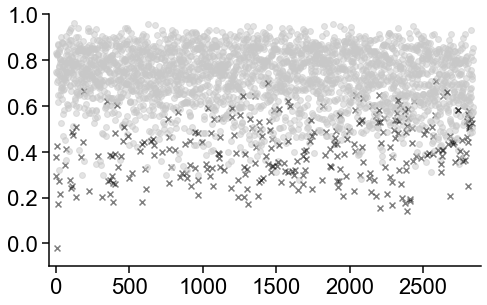

In [102]:
fig = plt.figure(figsize=(6, 3.5))
ax = fig.add_axes([0,0,1,1])

colors = ["#c8c8c8" if fdr < fdr_thres else "black" for fdr in data["fdr"]]
markers = ["o" if fdr < fdr_thres else "x" for fdr in data["fdr"]]
for i in range(len(data)):
    plt.scatter(i, data["similarity"].values[i], s=35, alpha=0.5, 
                marker=markers[i], color=colors[i])

plt.xlim(-50, len(data)+50)
plt.ylim([-0.1,1])
plt.xticks(fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)
ax.xaxis.set_tick_params(width=1.5, length=7)
ax.yaxis.set_tick_params(width=1.5, length=7)
for side in ["right", "top"]:
    ax.spines[side].set_visible(False)

plt.savefig("figures/similarity_dotplot.png", dpi=250, bbox_inches="tight")
plt.show()

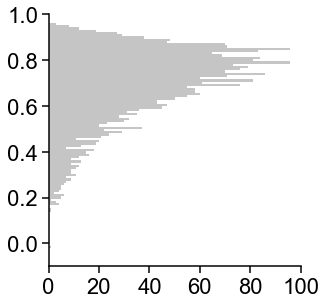

In [103]:
fig = plt.figure(figsize=(3.5, 3.5))
ax = fig.add_axes([0,0,1,1])

plt.hist(data["similarity"], bins=100, color="gray", alpha=0.45,
         orientation="horizontal")

plt.xlim([0,100])
plt.ylim([-0.1,1])
plt.xticks(fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)
ax.xaxis.set_tick_params(width=1.5, length=7)
ax.yaxis.set_tick_params(width=1.5, length=7)
for side in ["right", "top"]:
    ax.spines[side].set_visible(False)
    
plt.savefig("figures/similarity_histogram.png", dpi=250, bbox_inches="tight")
plt.show()